In [4]:
import torch
from torchvision import transforms

from PIL import Image
import numpy as np

from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
from diffusers import KandinskyV22PriorPipeline, KandinskyV22Pipeline

In [2]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    'laion/CLIP-ViT-bigG-14-laion2B-39B-b160k',
    torch_dtype=torch.float16,
    local_files_only=True
).cuda()

image_processor = CLIPImageProcessor.from_pretrained(
    'laion/CLIP-ViT-bigG-14-laion2B-39B-b160k',
    local_files_only=True
)

prior_pipe = KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", 
    local_files_only=True,
    torch_dtype=torch.float16
).to('cuda')

decoder_pipe = KandinskyV22Pipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", 
    local_files_only=True,
    torch_dtype=torch.float16
).to('cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
clip_mean = prior_pipe.prior.clip_mean
clip_std = prior_pipe.prior.clip_std

# use clip vision embeds as guidance

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

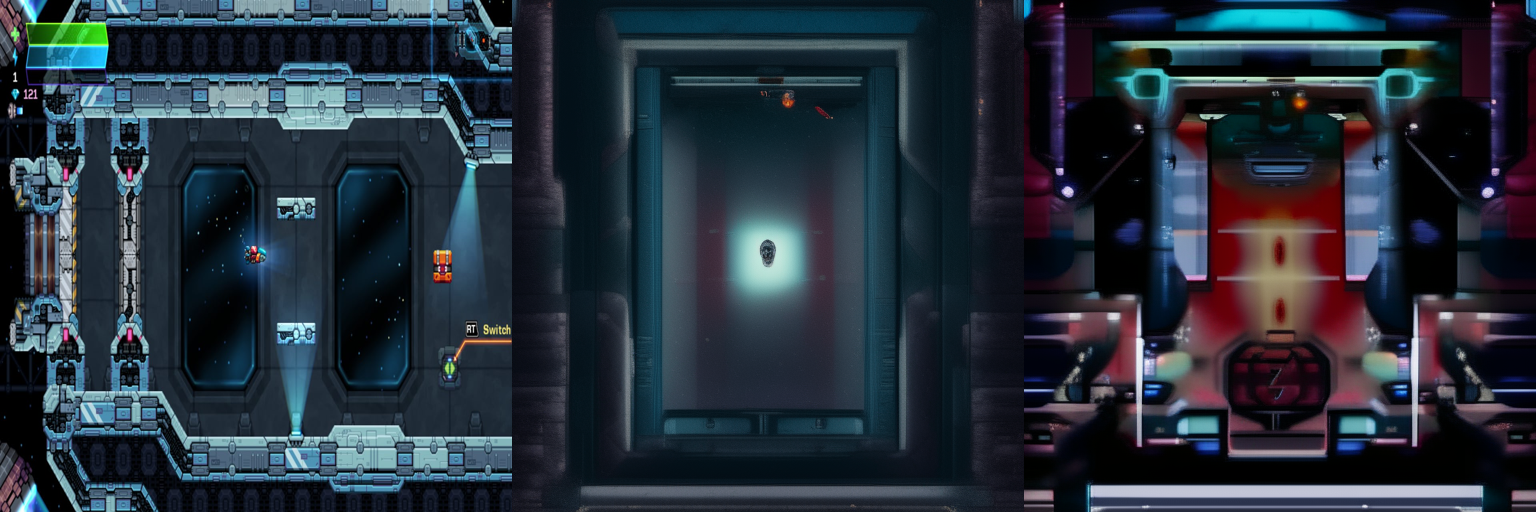

In [24]:
image = Image.open('./data/test-images/image0.jpg').convert("RGB")

pixel_values = image_processor(image, return_tensors="pt")['pixel_values']
image_embeds = image_encoder(pixel_values=pixel_values.cuda().half()).image_embeds

norm_image_embeds = (image_embeds - clip_mean) / clip_std

negative_image_embeds = None

with torch.no_grad():
    
    result_image = decoder_pipe(
        image_embeds=image_embeds, 
        negative_image_embeds=negative_image_embeds, 
        guidance_scale=0.,
        num_inference_steps=25,
        generator=torch.Generator(device="cuda").manual_seed(42)
    )
    
    norm_result_image = decoder_pipe(
        image_embeds=norm_image_embeds, 
        negative_image_embeds=negative_image_embeds, 
        guidance_scale=0.,
        num_inference_steps=25,
        generator=torch.Generator(device="cuda").manual_seed(42)
    )

Image.fromarray(np.concatenate([
    np.array(image.resize((512, 512))), 
    np.array(result_image.images[0]), 
    np.array(norm_result_image.images[0])
], axis=1))

# check prior CLIP and laion CLIP

In [21]:
params1 = list(image_encoder.named_parameters())
params2 = list(prior_pipe.image_encoder.named_parameters())

if len(params1) != len(params2):
    print("different number of parameters")

for (n1, p1), (n2, p2) in zip(params1, params2):
    if n1 != n2:
        print(f"different name: {n1} {n2}")
        continue
    if p1.shape != p2.shape:
        print(f"different shape: {n1}", p1.shape, p2.shape)
        continue
    if not torch.equal(p1, p2):
        print(f"different value: {n1}")